In [8]:
import numpy as np 
import pandas as pd 
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
sns.set_palette('Set2')
sns.set_style('whitegrid')

import matplotlib.pyplot as plt
%matplotlib inline

import requests
import json
import datetime
import time

from sklearn.preprocessing import KBinsDiscretizer

In [9]:
file = 'csv/CSV_for_EDA.csv'

In [10]:
df = pd.read_csv(file, index_col='date', parse_dates=True)

In [11]:
df.head()

,sales,covers,outside,apparent_temperature,humidity,precip_intensity_max,precip_max_time,precip_prob,precip_type,pressure,summary,temperature,day_of_week,month
date,,,,,,,,,,,,,,
2017-01-02,13159.84,173,0,35.58,0.92,0.0242,15:00:00,0.79,rain,1027.98,rain,39.06,0,1
2017-01-03,12442.11,178,0,41.50,0.94,0.0913,17:00:00,0.77,rain,1000.08,rain,43.19,1,1
2017-01-04,12927.64,172,0,36.81,0.40,0.0176,00:00:00,0.00,rain,1002.55,clear-night,42.29,2,1
2017-01-05,14457.79,188,0,27.11,0.48,0.0000,05:01:00,0.00,none,1014.61,cloudy,31.36,3,1
2017-01-06,15331.97,192,0,24.74,0.48,0.0019,12:00:00,0.00,snow,1022.80,partly-cloudy-night,29.42,4,1


In [12]:
def clean_up_for_eda(df):
    
    df['outside'] = df['outside'].replace({0: 'outside_closed',
                              1: 'outside_open'})

    df['day_of_week'] = df['day_of_week'].replace({0: 'Mon', 
                       1: 'Tue',
                       2: 'Wed',
                       3: 'Thu',
                       4: 'Fri',
                       5: 'Sat',
                       6: 'Sun'})

    df['year'] = df.index.year
    
    # Drop Closed Nights for EDA
    df = df[df.sales > 0]
    
    temp_enc = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='kmeans')
    x = temp_enc.fit_transform(df[['apparent_temperature']])
    
    temp = pd.DataFrame(x, index=df.index)
    
    temp = temp.replace({0: 'very_cold',
                    1: 'cold',
                    2: 'warm',
                    3: 'hot'})
    
    df = df.merge(temp, on='date', how='left')
    
    df = df.rename(columns={0: 'temperature_bin'})
    
    return df

df = clean_up_for_eda(df)

In [13]:
def clean_eda_outliers(X):
    
    z_thresh = 2
    
    for c in ['sales', 'covers']:

            count = 0

            for d in X['day_of_week'].unique():

                # Median / Mean / STD for each day of the week
                daily_median = np.median(X[X['day_of_week'] == d][c])
                daily_mean = np.mean(X[X['day_of_week'] == d][c])
                daily_std = np.std(X[X['day_of_week'] == d ][c])

                # Temporary column encoded if Target Columns have an Outlier
                X['temp_col'] = np.where((X['day_of_week'] == d) &  
                                         ((np.abs(X[c] - daily_mean)) > (daily_std * z_thresh)), 1, 0)

                # Replace Outlier with Median
                count += np.sum(X['temp_col'])
                X[c] = np.where(X['temp_col'] == 1, daily_median, X[c])
                X.drop(['temp_col'], axis=1, inplace=True)

            print(f'Outliers imputed - {c}: {count} -> {(count / len(X)*100):.2f}% of total')
            
    X['ppa'] = X['sales'] / X['covers']
    
    return X

df = clean_eda_outliers(df)

Outliers imputed - sales: 22 -> 2.45% of total
Outliers imputed - covers: 16 -> 1.78% of total


In [14]:
df.head()

,sales,covers,outside,apparent_temperature,humidity,precip_intensity_max,precip_max_time,precip_prob,precip_type,pressure,summary,temperature,day_of_week,month,year,temperature_bin,ppa
date,,,,,,,,,,,,,,,,,
2017-01-02,13159.84,173.0,outside_closed,35.58,0.92,0.0242,15:00:00,0.79,rain,1027.98,rain,39.06,Mon,1,2017,cold,76.068439
2017-01-03,12442.11,178.0,outside_closed,41.50,0.94,0.0913,17:00:00,0.77,rain,1000.08,rain,43.19,Tue,1,2017,cold,69.899494
2017-01-04,12927.64,172.0,outside_closed,36.81,0.40,0.0176,00:00:00,0.00,rain,1002.55,clear-night,42.29,Wed,1,2017,cold,75.160698
2017-01-05,14457.79,188.0,outside_closed,27.11,0.48,0.0000,05:01:00,0.00,none,1014.61,cloudy,31.36,Thu,1,2017,very_cold,76.903138
2017-01-06,15331.97,192.0,outside_closed,24.74,0.48,0.0019,12:00:00,0.00,snow,1022.80,partly-cloudy-night,29.42,Fri,1,2017,very_cold,79.854010


In [15]:
df.groupby('precip_type')['sales'].aggregate(['mean', 'count'])

,mean,count
precip_type,,
none,16694.392311,437
rain,16418.215499,431
sleet,17417.110000,1
snow,14463.659667,30


In [16]:
df[['sales', 'covers', 'ppa']].resample('Y').mean()

,sales,covers,ppa
date,,,
2017-12-31,16813.495794,221.998607,76.708644
2018-12-31,16322.919294,210.916898,77.985863
2019-12-31,16169.879134,214.432961,76.042510


In [17]:
df.groupby('outside')[['sales', 'covers', 'ppa']].mean()

,sales,covers,ppa
outside,,,
outside_closed,14837.668779,186.931579,79.603123
outside_open,18337.581486,248.654481,74.272230


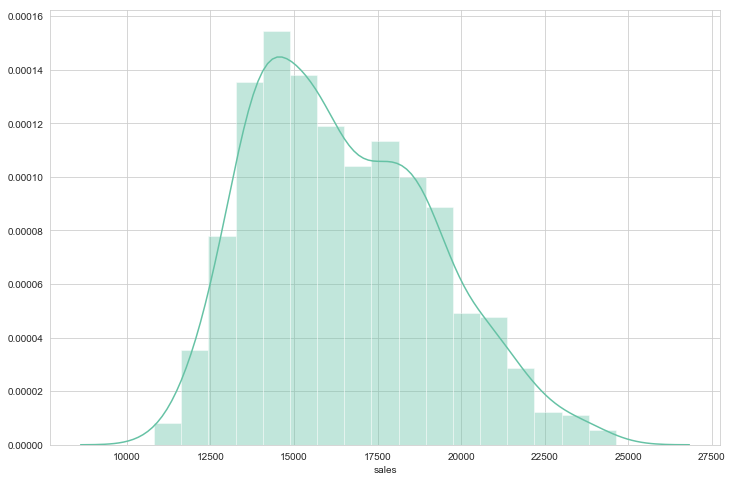

In [18]:
# Histogram of Sales
sns.set_style('whitegrid')
plt.figure(figsize=(12,8))
sns.distplot(df['sales']);

In [19]:
df_ytd = df[df.index.month < 6] # Analyzing Months 1 through 5
dfm_total = df.resample('M').sum()
dfm_avg = df.resample('M').mean()

In [20]:
x = pd.melt(df[['sales', 'covers']].resample('M').mean().reset_index(), id_vars='date')

In [21]:
df.groupby(['day_of_week', 'year'])['sales', 'covers', 'ppa'].mean()

sales      covers        ppa
day_of_week year                                     
Fri         2017  18289.426731  237.788462  78.151380
            2018  17684.693846  223.634615  79.565732
            2019  17625.731538  228.846154  77.703498
Mon         2017  15063.531373  202.833333  74.903606
            2018  15280.080577  200.951923  76.551919
            2019  14859.673200  198.060000  75.477091
Sat         2017  19486.565577  257.365385  76.291832
            2018  18736.813462  235.211538  80.184232
            2019  19346.790192  257.423077  76.147225
Sun         2017  16635.470200  236.630000  71.080551
            2018  16043.512549  222.509804  72.647739
            2019  15995.482800  227.080000  70.741132
Thu         2017  16694.993529  213.901961  79.058793
            2018  16170.392843  204.392157  79.997081
            2019  15526.488462  199.192308  78.245395
Tue         2017  15202.047843  194.725490  79.213959
            2018  14864.422745  191.960784  78.010463
            2019  14798.255600  192.880000  77.187589
Wed         2017  16248.666731  210.259615  78.102587
            2018  15444.164615  197.490385  78.880366
            2019  14926.877308  196.576923  76.614033

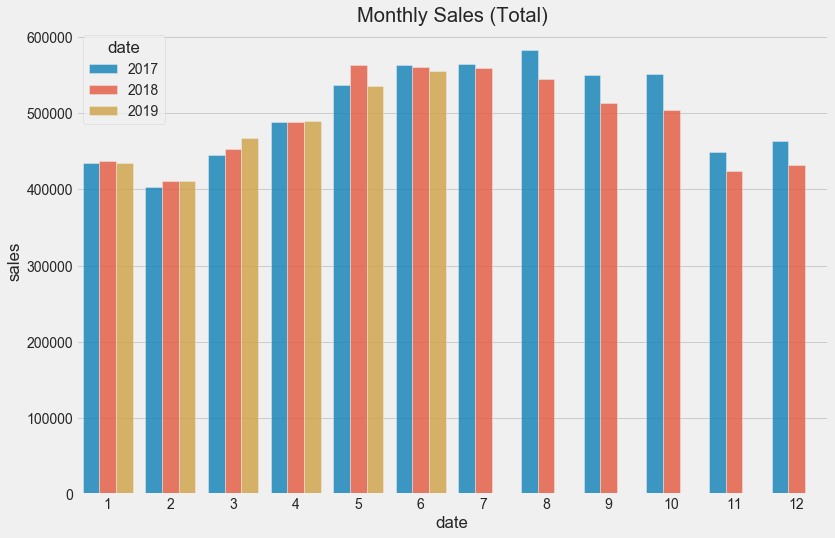

In [22]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12,8))

sns.barplot(x=dfm_total.index.month, y='sales', hue=dfm_total.index.year, data=dfm_total, alpha=0.85, ci=False)
plt.title('Monthly Sales (Total)');

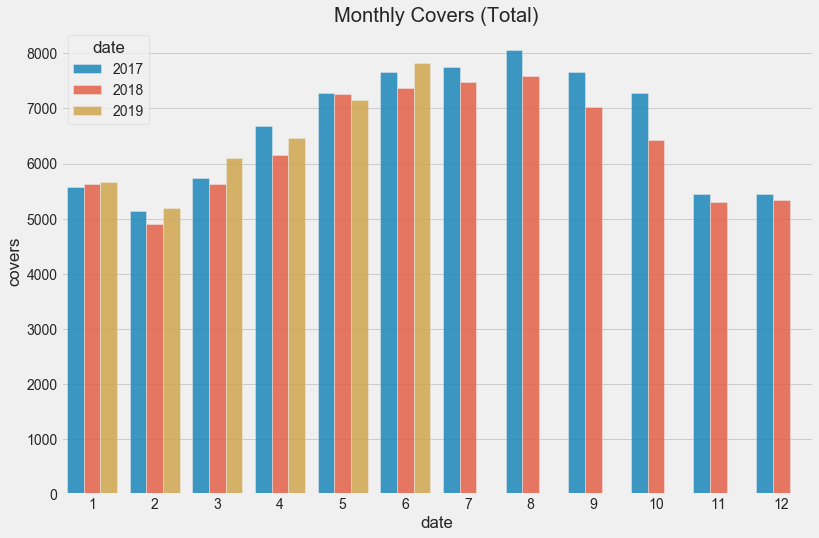

In [23]:
plt.figure(figsize=(12,8))
sns.barplot(x=dfm_total.index.month, y='covers', hue=dfm_total.index.year, data=dfm_total, alpha=0.85, ci=False)
plt.title('Monthly Covers (Total)');

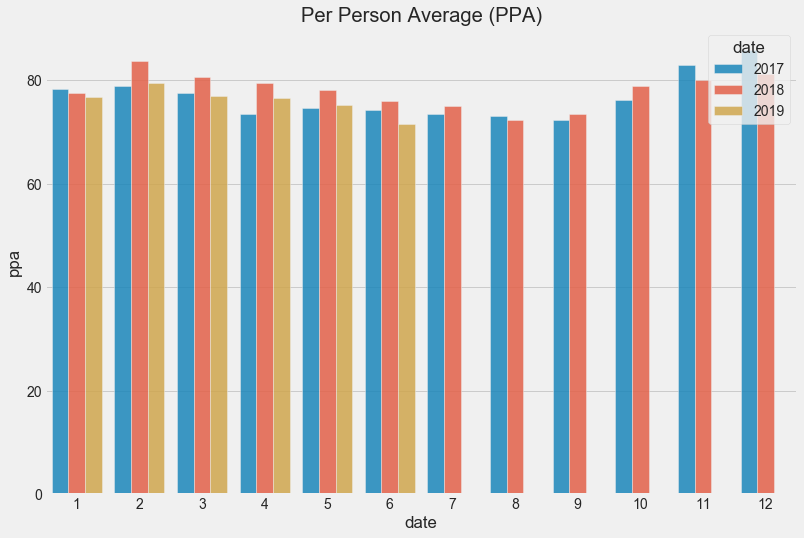

In [24]:
plt.figure(figsize=(12,8))
sns.barplot(x=dfm_avg.index.month, y='ppa', hue=dfm_avg.index.year, data=dfm_avg, alpha=0.85, ci=False)
plt.title('Per Person Average (PPA)');

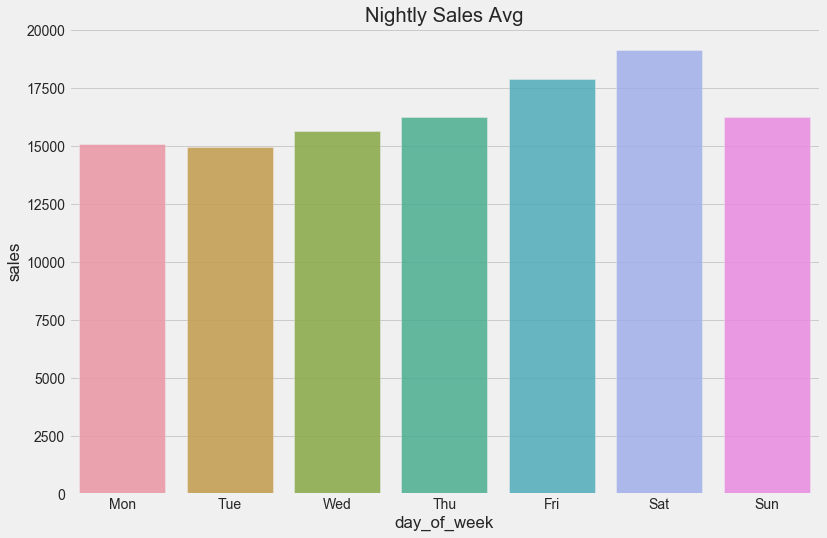

In [25]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12,8))
sns.barplot(x='day_of_week', y='sales', data=df, alpha=0.85, ci=False)
plt.title('Nightly Sales Avg');

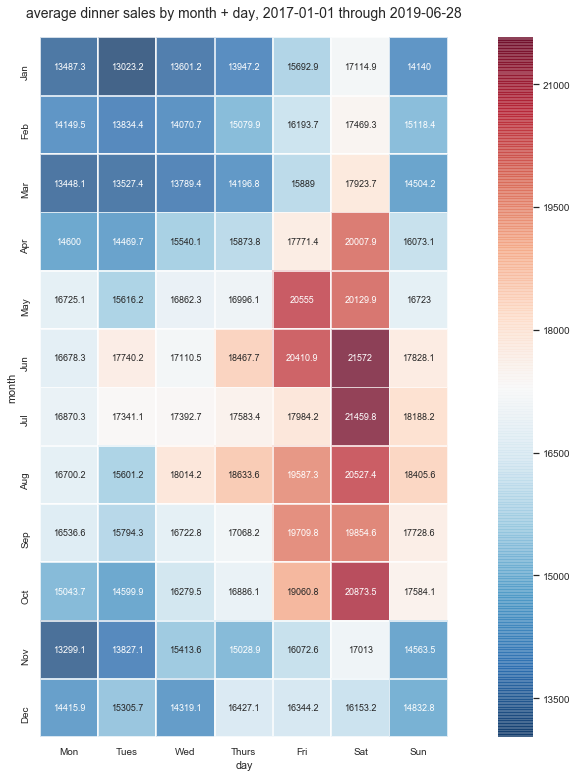

In [26]:
def sales_heatmap(df, start_date, end_date):
    
    sns.set_style('whitegrid')
    temp_df = df[(df.index > start_date) & (df.index < end_date)]
    
    matrix = temp_df.groupby([temp_df.index.month, temp_df.index.dayofweek]).agg({'sales': 'mean'})
    matrix = matrix.rename_axis(['month', 'day'])
    temp_df = matrix.unstack(level=1)

    plt.figure(figsize=(16,12))
    sns.set(font_scale=0.9)
    sns.set_style('whitegrid')
    sns.heatmap(temp_df, square=True, linewidths=0.75, annot=True, annot_kws={"size": 9}, fmt='g', 
                cmap='RdBu_r', alpha=0.75, yticklabels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
                xticklabels=['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'])
    plt.ylabel('month')
    plt.xlabel('day')
    plt.title(f'average dinner sales by month + day, {start_date} through {end_date}',size=14, pad=20)
    plt.show();
    
sales_heatmap(df, '2017-01-01', '2019-06-28')

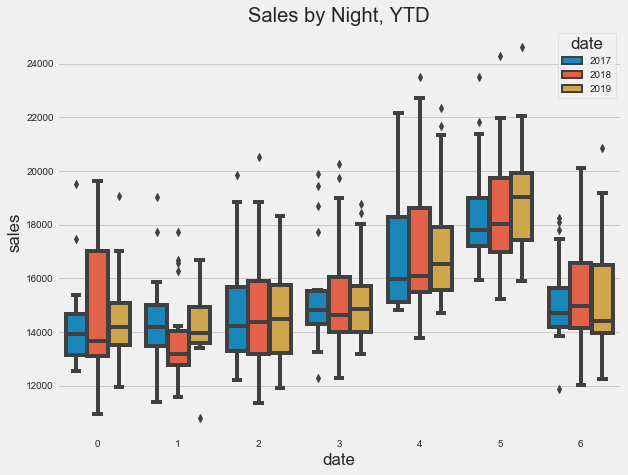

In [27]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(9,7))
sns.boxplot(x=df_ytd.index.dayofweek,
               y=df_ytd.sales,
               hue=df_ytd.index.year,
               data=df_ytd
                );

plt.title('Sales by Night, YTD');

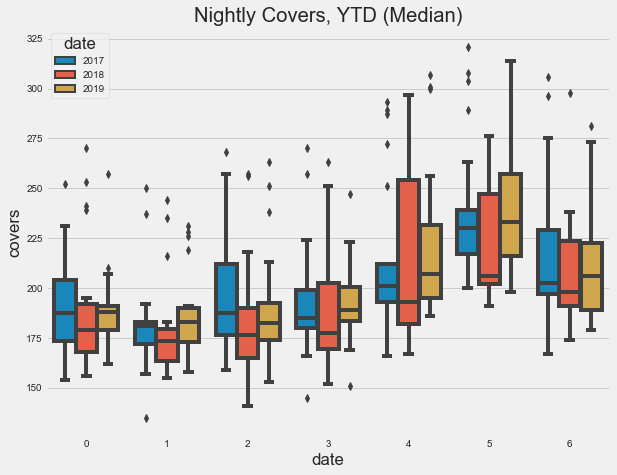

In [28]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(9,7))
sns.boxplot(x=df_ytd.index.dayofweek,
               y='covers',
               hue=df_ytd.index.year,
               data=df_ytd
                );

plt.title('Nightly Covers, YTD (Median)');

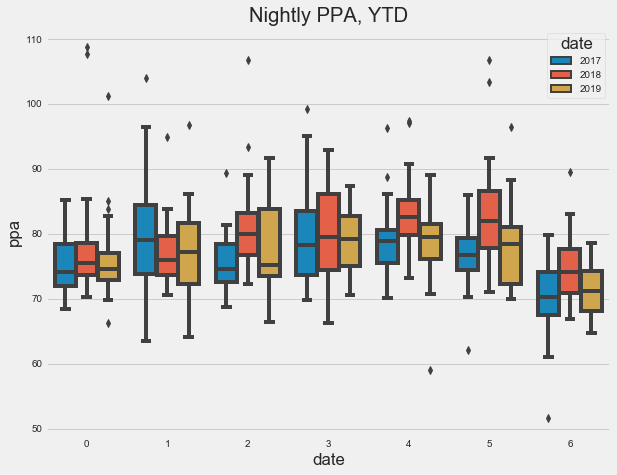

In [29]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(9,7))
sns.boxplot(x=df_ytd.index.dayofweek,
               y='ppa',
               hue=df_ytd.index.year,
               data=df_ytd
                );

plt.title('Nightly PPA, YTD');

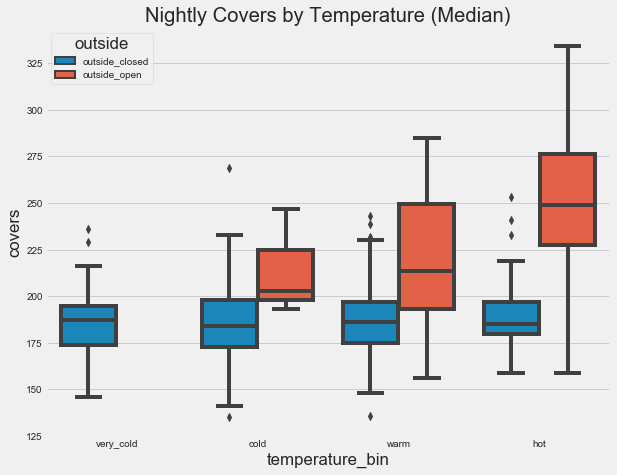

In [30]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(9,7))
sns.boxplot(x='temperature_bin',
               y='covers',
               hue='outside',
               data=df,
               order=['very_cold', 'cold', 'warm', 'hot']
                );

plt.title('Nightly Covers by Temperature (Median)');

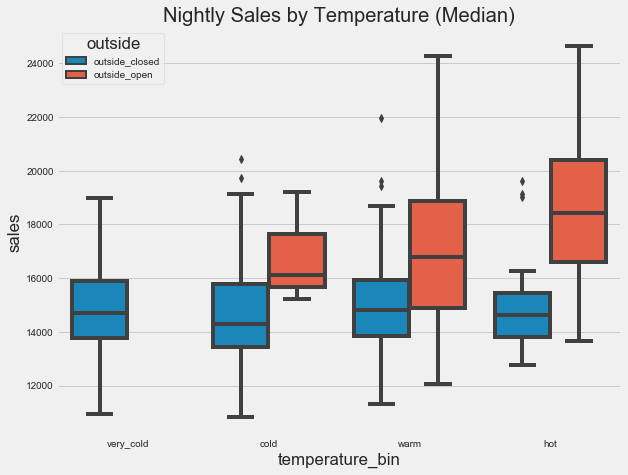

In [31]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(9,7))
sns.boxplot(x='temperature_bin',
               y='sales',
               hue='outside',
               data=df,
               order=['very_cold', 'cold', 'warm', 'hot']
                );

plt.title('Nightly Sales by Temperature (Median)');

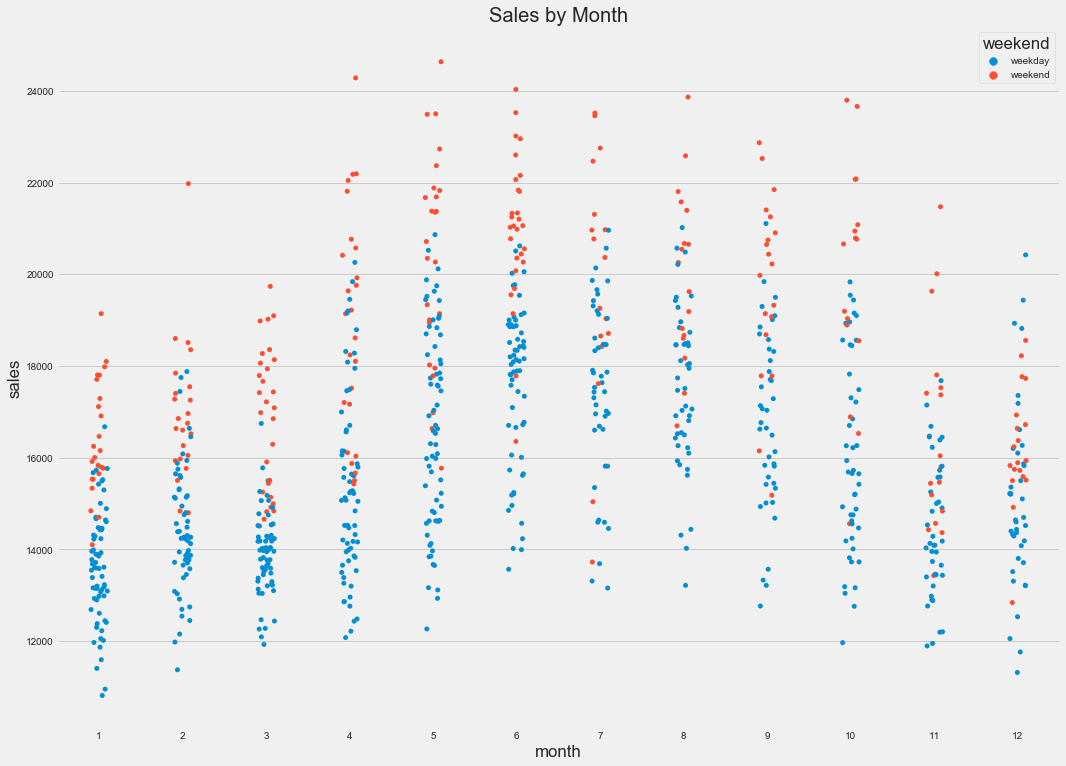

In [32]:
df['weekend'] = np.where((df['day_of_week'] == 'Fri') | (df['day_of_week'] == 'Sat'), 'weekend', 'weekday')

plt.style.use('fivethirtyeight')
plt.figure(figsize=(16,12))
sns.stripplot(x='month',
               y='sales',
               hue='weekend',
               data=df
                );

plt.title('Sales by Month');

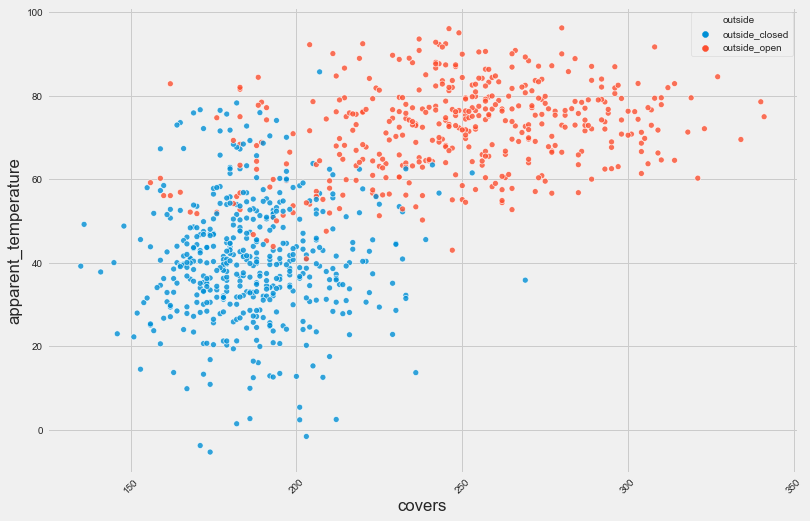

In [33]:
def scatter_plot(col_1, col_2, col_hue, data):
    
    plt.figure(figsize=(12,8))
    sns.scatterplot(x=col_1, y=col_2, hue=col_hue, data=data, alpha=.8)
    plt.xticks(rotation=45)
    plt.show();
    
scatter_plot('covers', 'apparent_temperature', 'outside', df)

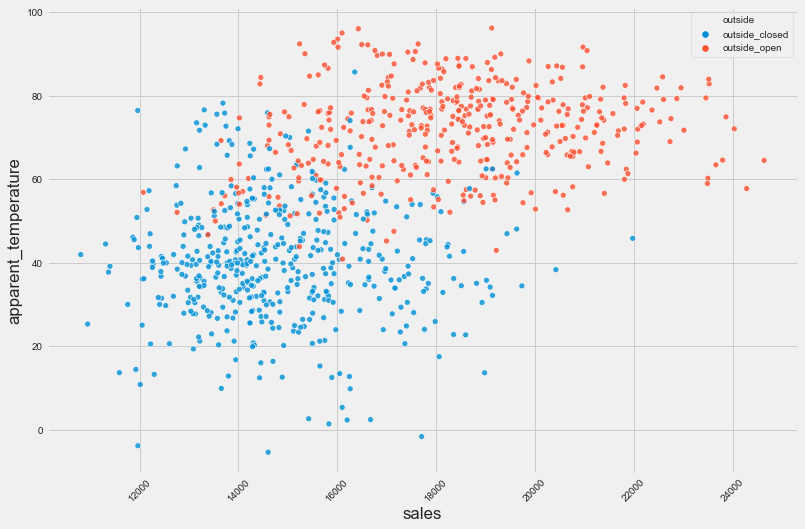

In [34]:
def scatter_plot(col_1, col_2, col_hue, data):
    
    plt.figure(figsize=(12,8))
    sns.scatterplot(x=col_1, y=col_2, hue=col_hue, data=data, alpha=.8)
    plt.xticks(rotation=45)
    plt.show();
    
scatter_plot('sales', 'apparent_temperature', 'outside', df)

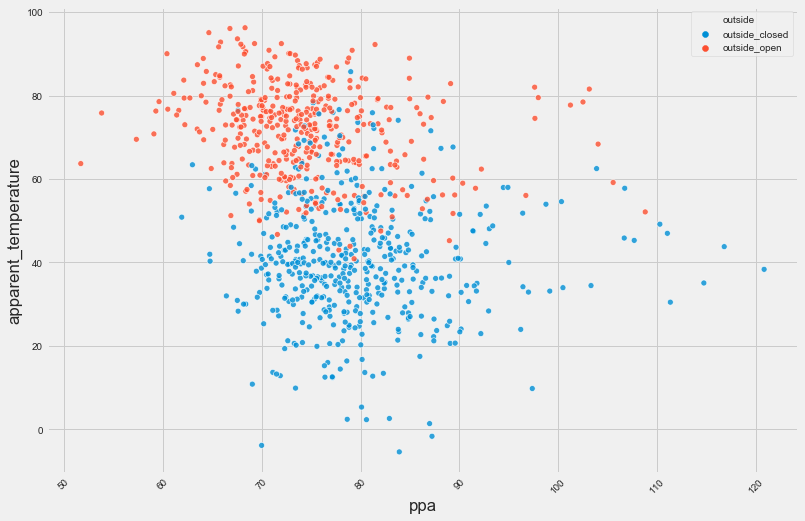

In [35]:
def scatter_plot(col_1, col_2, col_hue, data):
    
    plt.figure(figsize=(12,8))
    sns.scatterplot(x=col_1, y=col_2, hue=col_hue, data=data, alpha=.8)
    plt.xticks(rotation=45)
    plt.show();
    
scatter_plot('ppa', 'apparent_temperature', 'outside', df)

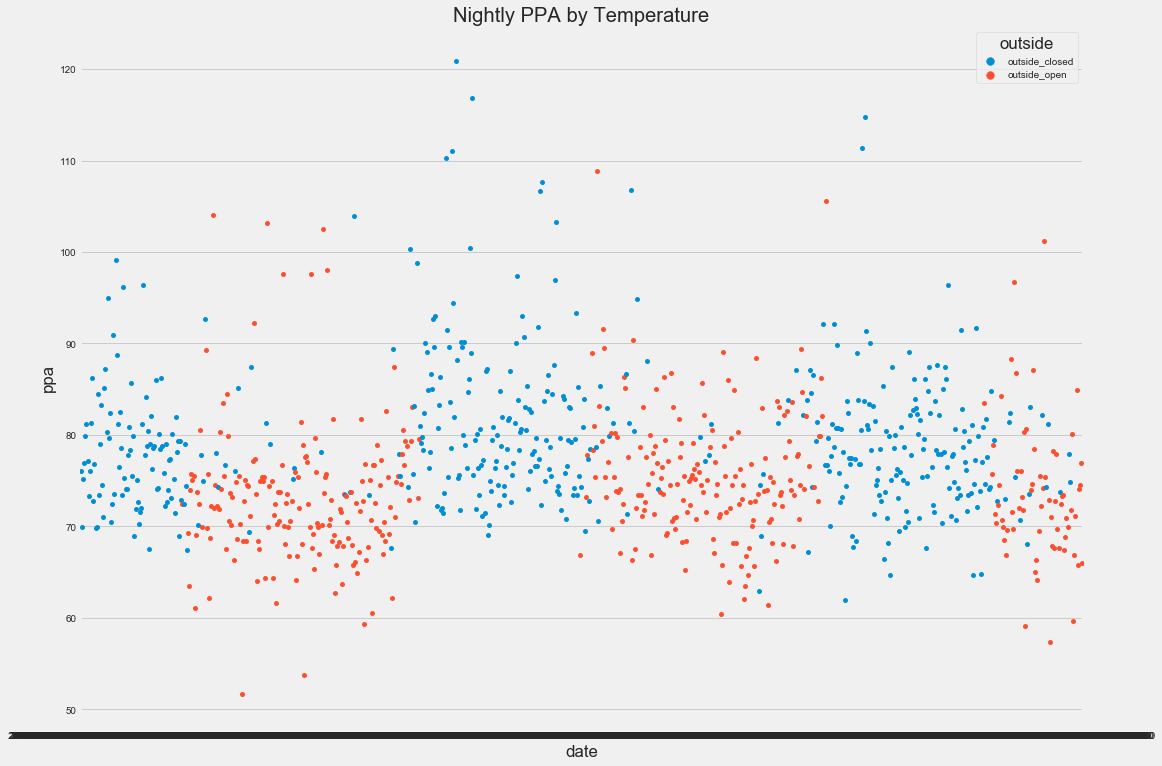

In [36]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(16,12))

sns.stripplot(x=df.index,
               y='ppa',
               hue='outside',
               data=df
                )

plt.title('Nightly PPA by Temperature');

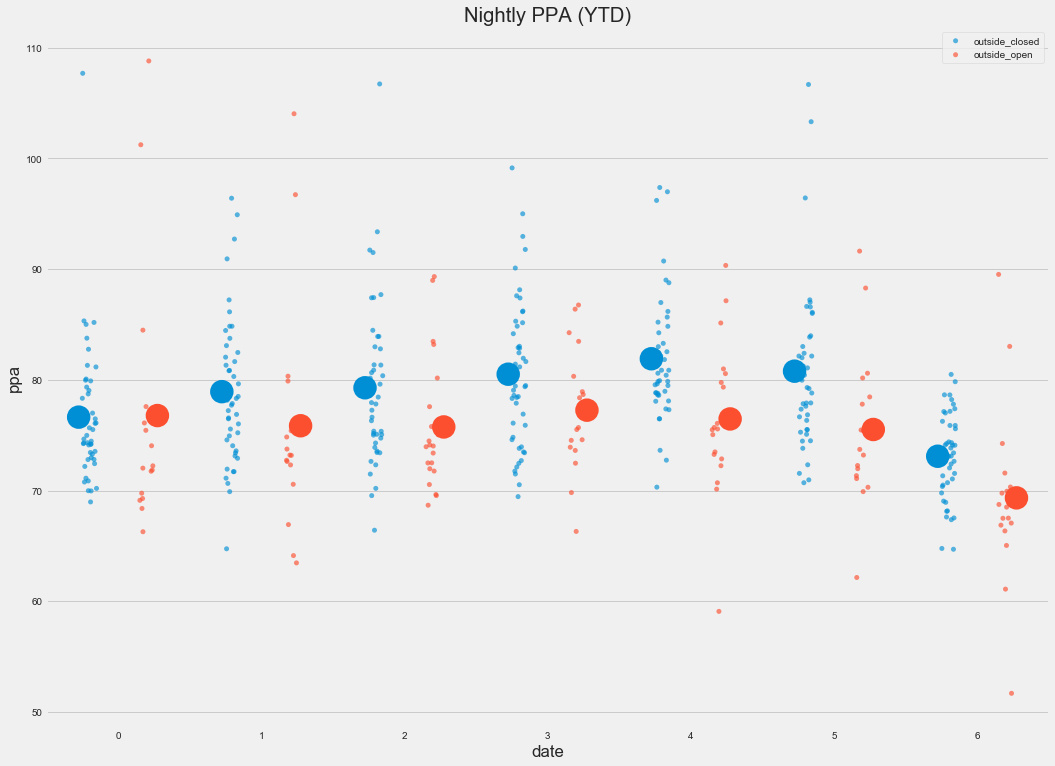

In [37]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(16,12))
sns.stripplot(x=df_ytd.index.dayofweek,
               y='ppa',
               hue='outside',
               data=df_ytd,
               dodge=0.35,
               alpha=0.65
                );

sns.pointplot(x=df_ytd.index.dayofweek,
               y='ppa',
               hue='outside',
               data=df_ytd,
               dodge=0.55,
               alpha=0.75,
               join=False,
               ci=None
                );


plt.legend(['outside_closed', 'outside_open'])
plt.title('Nightly PPA (YTD)');

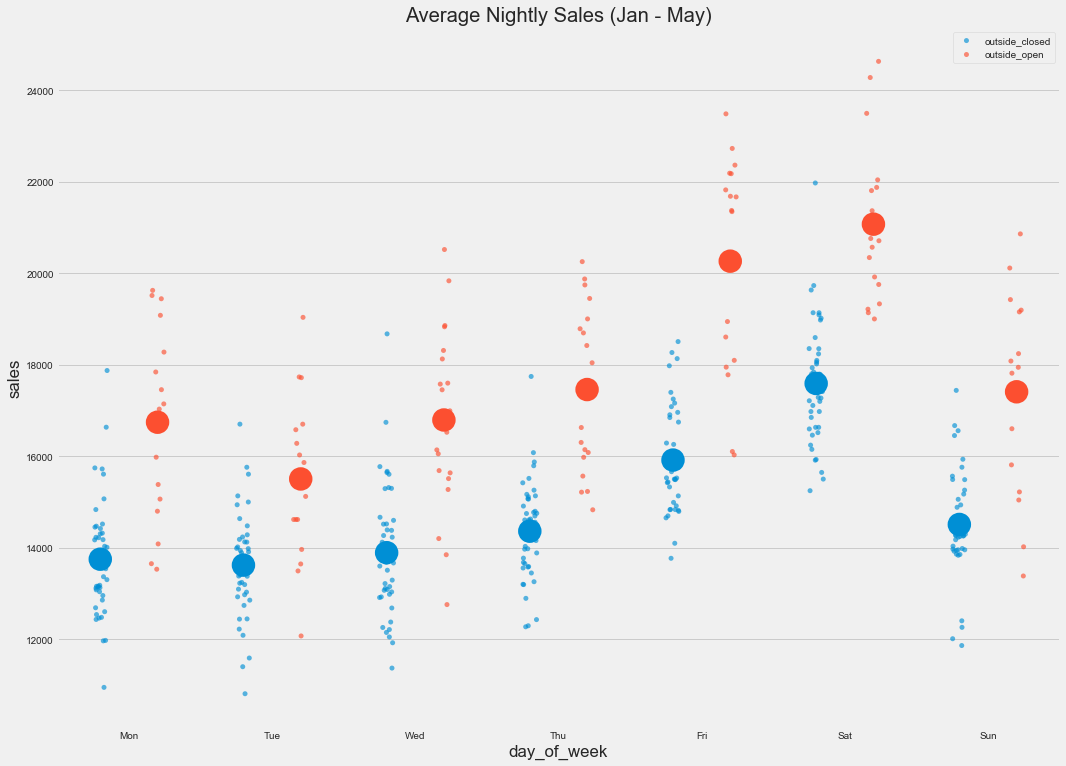

In [38]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(16,12))
sns.stripplot(x='day_of_week',
               y='sales',
               hue='outside',
               data=df_ytd,
               dodge=0.05,
               alpha=0.65
                );

sns.pointplot(x='day_of_week',
               y='sales',
               hue='outside',
               data=df_ytd,
               dodge=0.40,
               alpha=0.75,
               join=False,
               ci=None
                );


plt.legend(['outside_closed', 'outside_open'])
plt.title('Average Nightly Sales (Jan - May)');

In [39]:
df_ytd.head()

,sales,covers,outside,apparent_temperature,humidity,precip_intensity_max,precip_max_time,precip_prob,precip_type,pressure,summary,temperature,day_of_week,month,year,temperature_bin,ppa
date,,,,,,,,,,,,,,,,,
2017-01-02,13159.84,173.0,outside_closed,35.58,0.92,0.0242,15:00:00,0.79,rain,1027.98,rain,39.06,Mon,1,2017,cold,76.068439
2017-01-03,12442.11,178.0,outside_closed,41.50,0.94,0.0913,17:00:00,0.77,rain,1000.08,rain,43.19,Tue,1,2017,cold,69.899494
2017-01-04,12927.64,172.0,outside_closed,36.81,0.40,0.0176,00:00:00,0.00,rain,1002.55,clear-night,42.29,Wed,1,2017,cold,75.160698
2017-01-05,14457.79,188.0,outside_closed,27.11,0.48,0.0000,05:01:00,0.00,none,1014.61,cloudy,31.36,Thu,1,2017,very_cold,76.903138
2017-01-06,15331.97,192.0,outside_closed,24.74,0.48,0.0019,12:00:00,0.00,snow,1022.80,partly-cloudy-night,29.42,Fri,1,2017,very_cold,79.854010


In [40]:
df_ytd.head()

,sales,covers,outside,apparent_temperature,humidity,precip_intensity_max,precip_max_time,precip_prob,precip_type,pressure,summary,temperature,day_of_week,month,year,temperature_bin,ppa
date,,,,,,,,,,,,,,,,,
2017-01-02,13159.84,173.0,outside_closed,35.58,0.92,0.0242,15:00:00,0.79,rain,1027.98,rain,39.06,Mon,1,2017,cold,76.068439
2017-01-03,12442.11,178.0,outside_closed,41.50,0.94,0.0913,17:00:00,0.77,rain,1000.08,rain,43.19,Tue,1,2017,cold,69.899494
2017-01-04,12927.64,172.0,outside_closed,36.81,0.40,0.0176,00:00:00,0.00,rain,1002.55,clear-night,42.29,Wed,1,2017,cold,75.160698
2017-01-05,14457.79,188.0,outside_closed,27.11,0.48,0.0000,05:01:00,0.00,none,1014.61,cloudy,31.36,Thu,1,2017,very_cold,76.903138
2017-01-06,15331.97,192.0,outside_closed,24.74,0.48,0.0019,12:00:00,0.00,snow,1022.80,partly-cloudy-night,29.42,Fri,1,2017,very_cold,79.854010


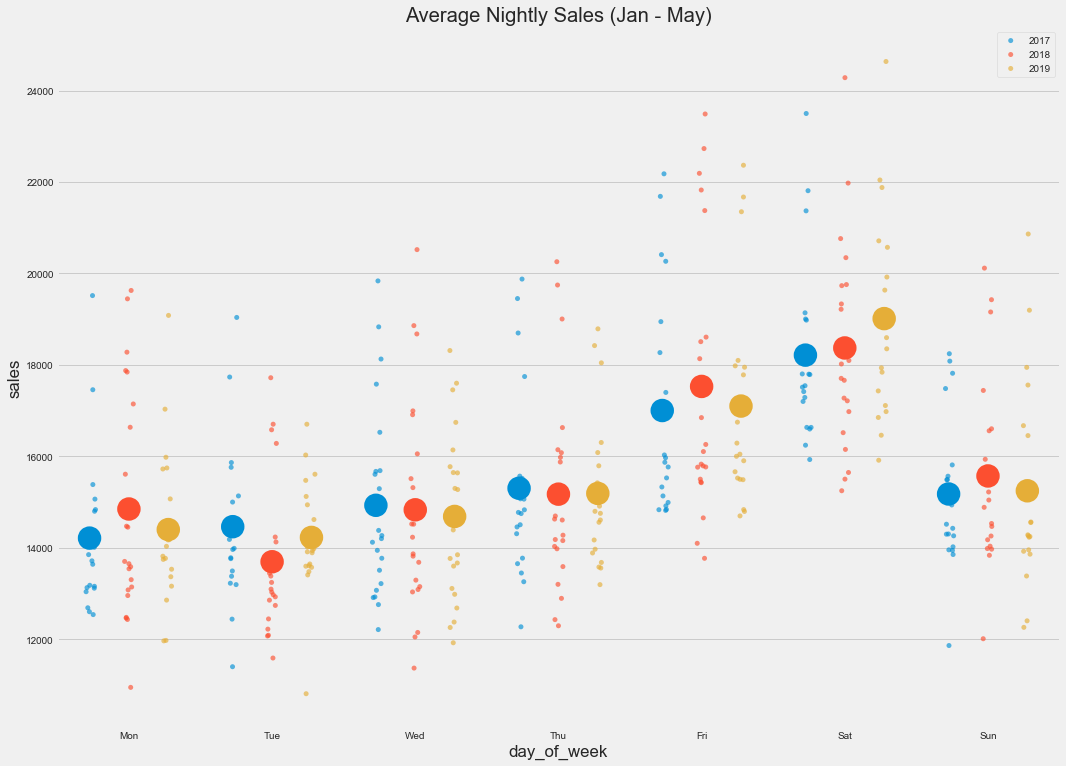

In [41]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(16,12))
sns.stripplot(x='day_of_week',
               y='sales',
               hue='year',
               data=df_ytd,
               dodge=0.35,
               alpha=0.65
                );

sns.pointplot(x='day_of_week',
               y='sales',
               hue='year',
               data=df_ytd,
               dodge=0.55,
               alpha=0.75,
               join=False,
               ci=None
                );


plt.legend(['2017', '2018', '2019'])
plt.title('Average Nightly Sales (Jan - May)');

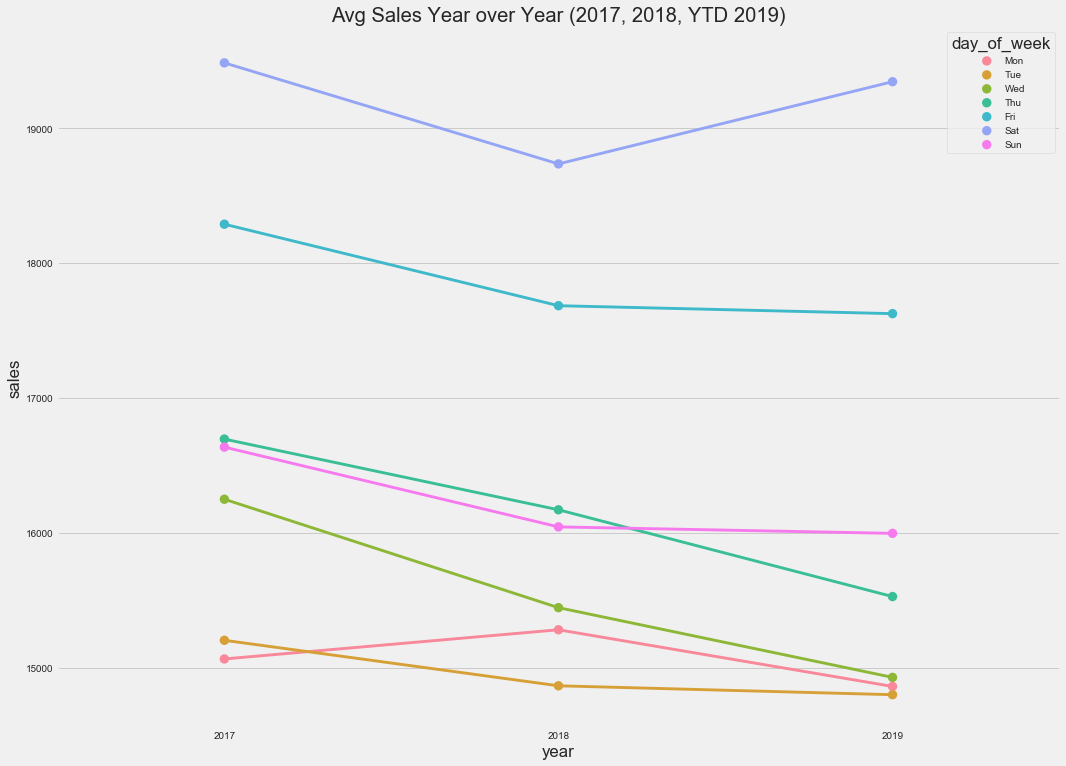

In [42]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(16,12))

sns.pointplot(x='year',
               y='sales',
               hue='day_of_week',
               data=df,
               alpha=0.75,
               join=True,
               ci=False,
               scale=0.4
                )

plt.title('Avg Sales Year over Year (2017, 2018, YTD 2019)');